In [2]:
import pandas as pd
import numpy as np  
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.util import ngrams

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm" , disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
 


import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/triyuliannibasukie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseV

In [3]:
tweets = pd.read_csv('2022 Twitter Tweets Jan-April_Amber Heard Data.csv')
tweets.head()

,id_str,created_at,full_text,lang,in_reply_to_status_id_str,in_reply_to_user_id,entities.hashtags,entities.media,entities.symbols,entities.urls,...,user.friends_count,user.lang,user.location,user.name,user.screen_name,user.profile_banner_url,user.profile_image_url,user.statuses_count,user.url,user.verified
0,1477504983130116096.0,2022-01-02 05:00:13+00:00,@la77465262 @Melinda15199317 @Dior So why is #...,en,1466075642244603909,1363630915298148352.0,"[{'indices': [45, 56], 'text': 'JohnnyDepp'}]","[{'original_info': {'width': 1058, 'focus_rect...",[],[],...,1898.0,NaN,NaN,Sean O'Connor,seano999,https://pbs.twimg.com/profile_banners/11497951...,http://pbs.twimg.com/profile_images/1442389537...,27033.0,NaN,False
1,1477503751716065280.0,2022-01-02 04:55:19+00:00,Only thing I want them to leave alone is the f...,en,NaN,NaN,[],NaN,[],[],...,1025.0,NaN,NaN,❤️‍🔥 Wilson the Opp Slayer 🔪,WonderWilson18,https://pbs.twimg.com/profile_banners/14262271...,http://pbs.twimg.com/profile_images/1515742990...,27853.0,https://t.co/dVvgQNht1k,False
2,1477499814719983616.0,2022-01-02 04:39:41+00:00,@soldierboy43001 @ZakReckless Yeah but Snyder ...,en,1477497121972621318,1297204830231040000.0,[],NaN,[],[],...,139.0,NaN,NaN,Steven Curry,StevenJCurry,https://pbs.twimg.com/profile_banners/14273589...,http://pbs.twimg.com/profile_images/1429534379...,199.0,NaN,False
3,1477497740498292736.0,2022-01-02 04:31:26+00:00,@IIMissMax @bg98021 @GerberKawasaki You forgot...,en,1477475212992073728,305017078.0,[],NaN,[],[],...,128.0,NaN,NaN,Vincent 1,Vincent72516869,NaN,http://pbs.twimg.com/profile_images/1354614785...,2313.0,NaN,False
4,1477496477484212224.0,2022-01-02 04:26:25+00:00,I never seen Aquaman nor will I because Amber ...,en,NaN,NaN,[],NaN,[],[],...,141.0,NaN,𝗡𝗢𝗧 𝗦𝗣𝗢𝗜𝗟𝗘𝗥 𝗙𝗥𝗘𝗘,𝐇𝐘𝐃𝐄,YoonJaysSimp,https://pbs.twimg.com/profile_banners/10769432...,http://pbs.twimg.com/profile_images/1516751870...,5423.0,https://t.co/XkBVR5FDCS,False


In [4]:
df = tweets.filter(['full_text', 'lang', "created_at"], axis=1)
df1 = df[df["lang"] == "en"]
df_jan = df1[(df1['created_at'] > '2022-03-01') & (df1['created_at'] < '2022-04-01')]
df2 = df_jan.dropna()
df2.head()

,full_text,lang,created_at
40717,@la77465262 Just because she is a woman should...,en,2022-03-08 11:37:36+00:00
40718,We aren’t just talking a violent phase over a ...,en,2022-03-08 11:27:12+00:00
40719,"After claiming he would, he had medical record...",en,2022-03-08 11:23:47+00:00
40720,Judge pls see THIS . \n#JusticeForJohnnyDeppVi...,en,2022-03-08 11:21:56+00:00
40721,So @wbpictures @warnerbros DOESN'T want us to...,en,2022-03-08 11:21:48+00:00


# Data cleaning

In [5]:
# Remove non-English words

# remove hashtags 
df2['clean_text']  = df2['full_text'].map(lambda x: re.sub("#[A-Za-z0-9_]+", " ", str(x)))

# remove mentions
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("@[A-Za-z0-9_]+"," ", str(x)))

# remove links
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub(r"http\S+"," ", str(x)))

# remove "&amp"
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("&amp"," ", str(x)))

# remove punc 
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))

# lower case
df2['clean_text']  = df2['clean_text'].apply(lambda x: x.lower())

# remove amber heard and johnny depp
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("amber","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("heard","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("johnny","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("depp","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("ah","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("jd","", str(x)))

# tokenize
df2['clean_text']  = [word_tokenize(row) for row in df2['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
stop_words.extend(new_stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df2['clean_text']  = df2['clean_text'].apply(lambda x: remove_stopwords(x))

In [6]:
df2.head()

,full_text,lang,created_at,clean_text
40717,@la77465262 Just because she is a woman should...,en,2022-03-08 11:37:36+00:00,"[woman, held, accountable, actions]"
40718,We aren’t just talking a violent phase over a ...,en,2022-03-08 11:27:12+00:00,"[talking, violent, phase, days, went, years, m..."
40719,"After claiming he would, he had medical record...",en,2022-03-08 11:23:47+00:00,"[claiming, would, medical, records, cctv, foot..."
40720,Judge pls see THIS . \n#JusticeForJohnnyDeppVi...,en,2022-03-08 11:21:56+00:00,"[judge, pls, see, physically, mentally, abused..."
40721,So @wbpictures @warnerbros DOESN'T want us to...,en,2022-03-08 11:21:48+00:00,"[want, us, share, together, hmm, duty, share, ..."


In [7]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df2['clean_text'] = df2['clean_text'].apply(lambda x: lemmatization(x))


df2.head()

,full_text,lang,created_at,clean_text
40717,@la77465262 Just because she is a woman should...,en,2022-03-08 11:37:36+00:00,"[woman, action]"
40718,We aren’t just talking a violent phase over a ...,en,2022-03-08 11:27:12+00:00,"[phase, day, year, text, friend, inform]"
40719,"After claiming he would, he had medical record...",en,2022-03-08 11:23:47+00:00,"[record, footage, bodycam, footage, lie, penth..."
40720,Judge pls see THIS . \n#JusticeForJohnnyDeppVi...,en,2022-03-08 11:21:56+00:00,"[relationship, pls, jail]"
40721,So @wbpictures @warnerbros DOESN'T want us to...,en,2022-03-08 11:21:48+00:00,"[hmm, duty, share, bishe]"


In [8]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df2['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '


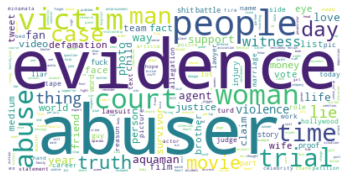

In [9]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("unigram_wordcloud_after.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

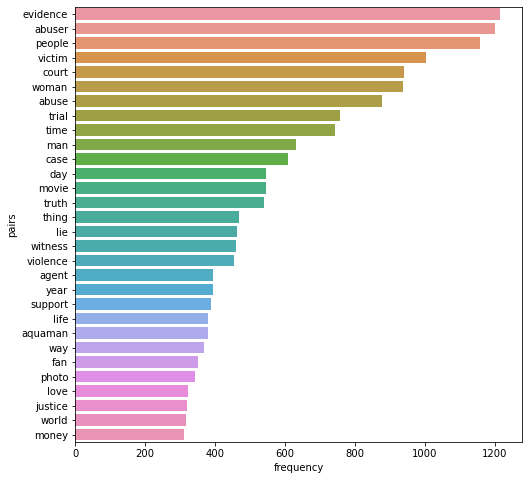

In [10]:
new_tokens = []
for i in df2["clean_text"].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

# Topic Modeling for Text


## Create Corpus 

In [11]:
data_lemmatized = df2['clean_text'].tolist()
print(data_lemmatized[:3])

[['woman', 'action'], ['phase', 'day', 'year', 'text', 'friend', 'inform'], ['record', 'footage', 'bodycam', 'footage', 'lie', 'penthouse', 'break', 'restraining', 'order']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [13]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'action'), (1, 'woman'), (2, 'day'), (3, 'friend'), (4, 'inform'), (5, 'phase'), (6, 'text'), (7, 'year'), (8, 'bodycam'), (9, 'break'), (10, 'footage'), (11, 'lie'), (12, 'order'), (13, 'penthouse'), (14, 'record'), (15, 'restraining'), (16, 'jail'), (17, 'pls'), (18, 'relationship'), (19, 'bishe'), (20, 'duty'), (21, 'hmm'), (22, 'share'), (23, 'abuse'), (24, 'gender'), (25, 'hero'), (26, 'imagine'), (27, 'mouth'), (28, 'people'), (29, 'proof'), (30, 'tweet'), (31, 'victim'), (32, 'worship'), (33, 'advantage'), (34, 'assault'), (35, 'frame'), (36, 'husband'), (37, 'metoo'), (38, 'movement'), (39, 'night'), (40, 'person'), (41, 'violence'), (42, 'abuser'), (43, 'charity'), (44, 'money'), (45, 'disservice'), (46, 'time'), (47, 'account'), (48, 'block'), (49, 'dear')]

Total Vocabulary Size: 3250


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [14]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [14]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.3572334167171184
Perplexity Score:  -6.8260455444464

topic number:  3
Coherence Score:  0.37720269057416705
Perplexity Score:  -6.880670927960594

topic number:  4
Coherence Score:  0.34560475253735
Perplexity Score:  -6.941679734895514

topic number:  5
Coherence Score:  0.3566882347751882
Perplexity Score:  -6.960403317227227

topic number:  6
Coherence Score:  0.3223313765883031
Perplexity Score:  -7.009936875040511

topic number:  7
Coherence Score:  0.35724595296202416
Perplexity Score:  -7.003226166835318

topic number:  8
Coherence Score:  0.3304134151035756
Perplexity Score:  -7.059064557604237

topic number:  9
Coherence Score:  0.3425606224945304
Perplexity Score:  -7.0794637378627225

topic number:  10
Coherence Score:  0.3695669428673313
Perplexity Score:  -7.069392651360786

topic number:  11
Coherence Score:  0.3758864169663596
Perplexity Score:  -7.128224399506244

topic number:  12
Coherence Score:  0.34750815911390687
Perplexity Sc

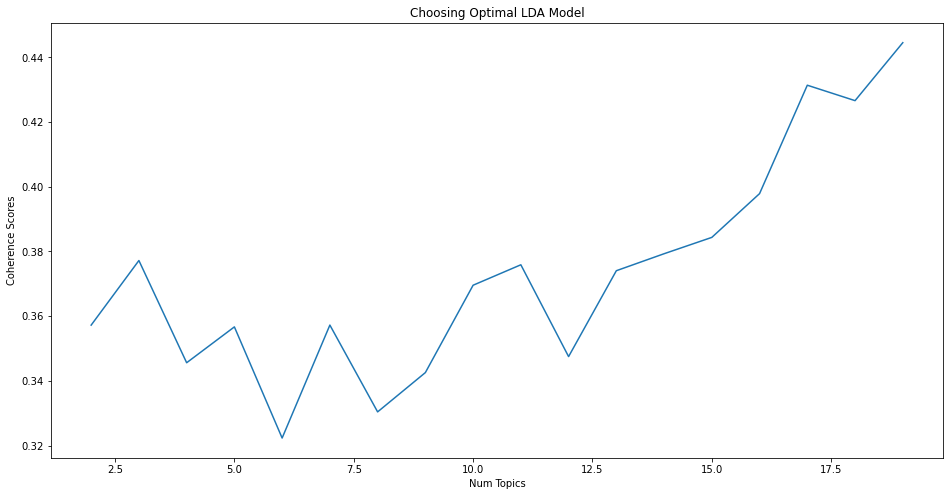

In [15]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [15]:
ntopics_des_name = 3

# We choose 3 because it has the highest coherence score reached before a major drop.

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [16]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.033*"trial" + 0.026*"day" + 0.018*"photo" + 0.016*"love" + 0.013*"team" + '
  '0.012*"wife" + 0.012*"time" + 0.012*"defamation" + 0.011*"injury" + '
  '0.011*"vote"'),
 (1,
  '0.047*"court" + 0.025*"movie" + 0.024*"abuser" + 0.020*"agent" + '
  '0.018*"aquaman" + 0.018*"time" + 0.017*"fan" + 0.015*"people" + '
  '0.012*"film" + 0.011*"support"'),
 (2,
  '0.042*"evidence" + 0.032*"victim" + 0.029*"abuse" + 0.028*"woman" + '
  '0.027*"people" + 0.021*"abuser" + 0.020*"man" + 0.018*"witness" + '
  '0.017*"truth" + 0.016*"thing"')]


In [17]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [18]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df2)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [19]:
df2['Topic'] = topic_num

In [20]:
des_name_final = df2[['full_text', 'clean_text', 'Topic']]
des_name_final.head()

,full_text,clean_text,Topic
40717,@la77465262 Just because she is a woman should...,"[woman, action]","[2, 1, 0]"
40718,We aren’t just talking a violent phase over a ...,"[phase, day, year, text, friend, inform]","[0, 2, 1]"
40719,"After claiming he would, he had medical record...","[record, footage, bodycam, footage, lie, penth...","[2, 0, 1]"
40720,Judge pls see THIS . \n#JusticeForJohnnyDeppVi...,"[relationship, pls, jail]","[2, 1, 0]"
40721,So @wbpictures @warnerbros DOESN'T want us to...,"[hmm, duty, share, bishe]","[0, 1, 2]"


### Model Evaluation

In [21]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -6.877127620585083
Coherence Score:  0.33368294667818804


## Visualisation

In [22]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.056821 -0.292126       1        1  41.805838
0     -0.295231  0.099406       2        1  29.137563
1      0.238410  0.192721       3        1  29.056599, topic_info=         Term         Freq        Total Category  logprob  loglift
80      court   928.000000   928.000000  Default  30.0000  30.0000
61   evidence  1186.000000  1186.000000  Default  29.0000  29.0000
31     victim   909.000000   909.000000  Default  28.0000  28.0000
155     trial   686.000000   686.000000  Default  27.0000  27.0000
23      abuse   815.000000   815.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
44      money   196.009750   294.480683   Topic3  -4.6148   0.8289
152   support   213.903540   356.049147   Topic3  -4.5274   0.7264
416       eye   164.582610   237.959484   Topic3  -4.7895   0.8672
28     people   287.849520  1066.527407   Topic3  -4.2305  -0.0738
179     child   118.956096   223.975869   Topic3  -5.1142   0.6031

[150 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
23        1  0.998741   abuse
42        1  0.555227  abuser
42        3  0.444739  abuser
854       1  0.994047   actor
376       3  0.998683   agent
...     ...       ...     ...
409       3  0.990289  wonder
133       1  0.849024   world
133       3  0.148833   world
7         1  0.502678    year
7         2  0.494865    year

[149 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

## Word Count of Topic Keywords

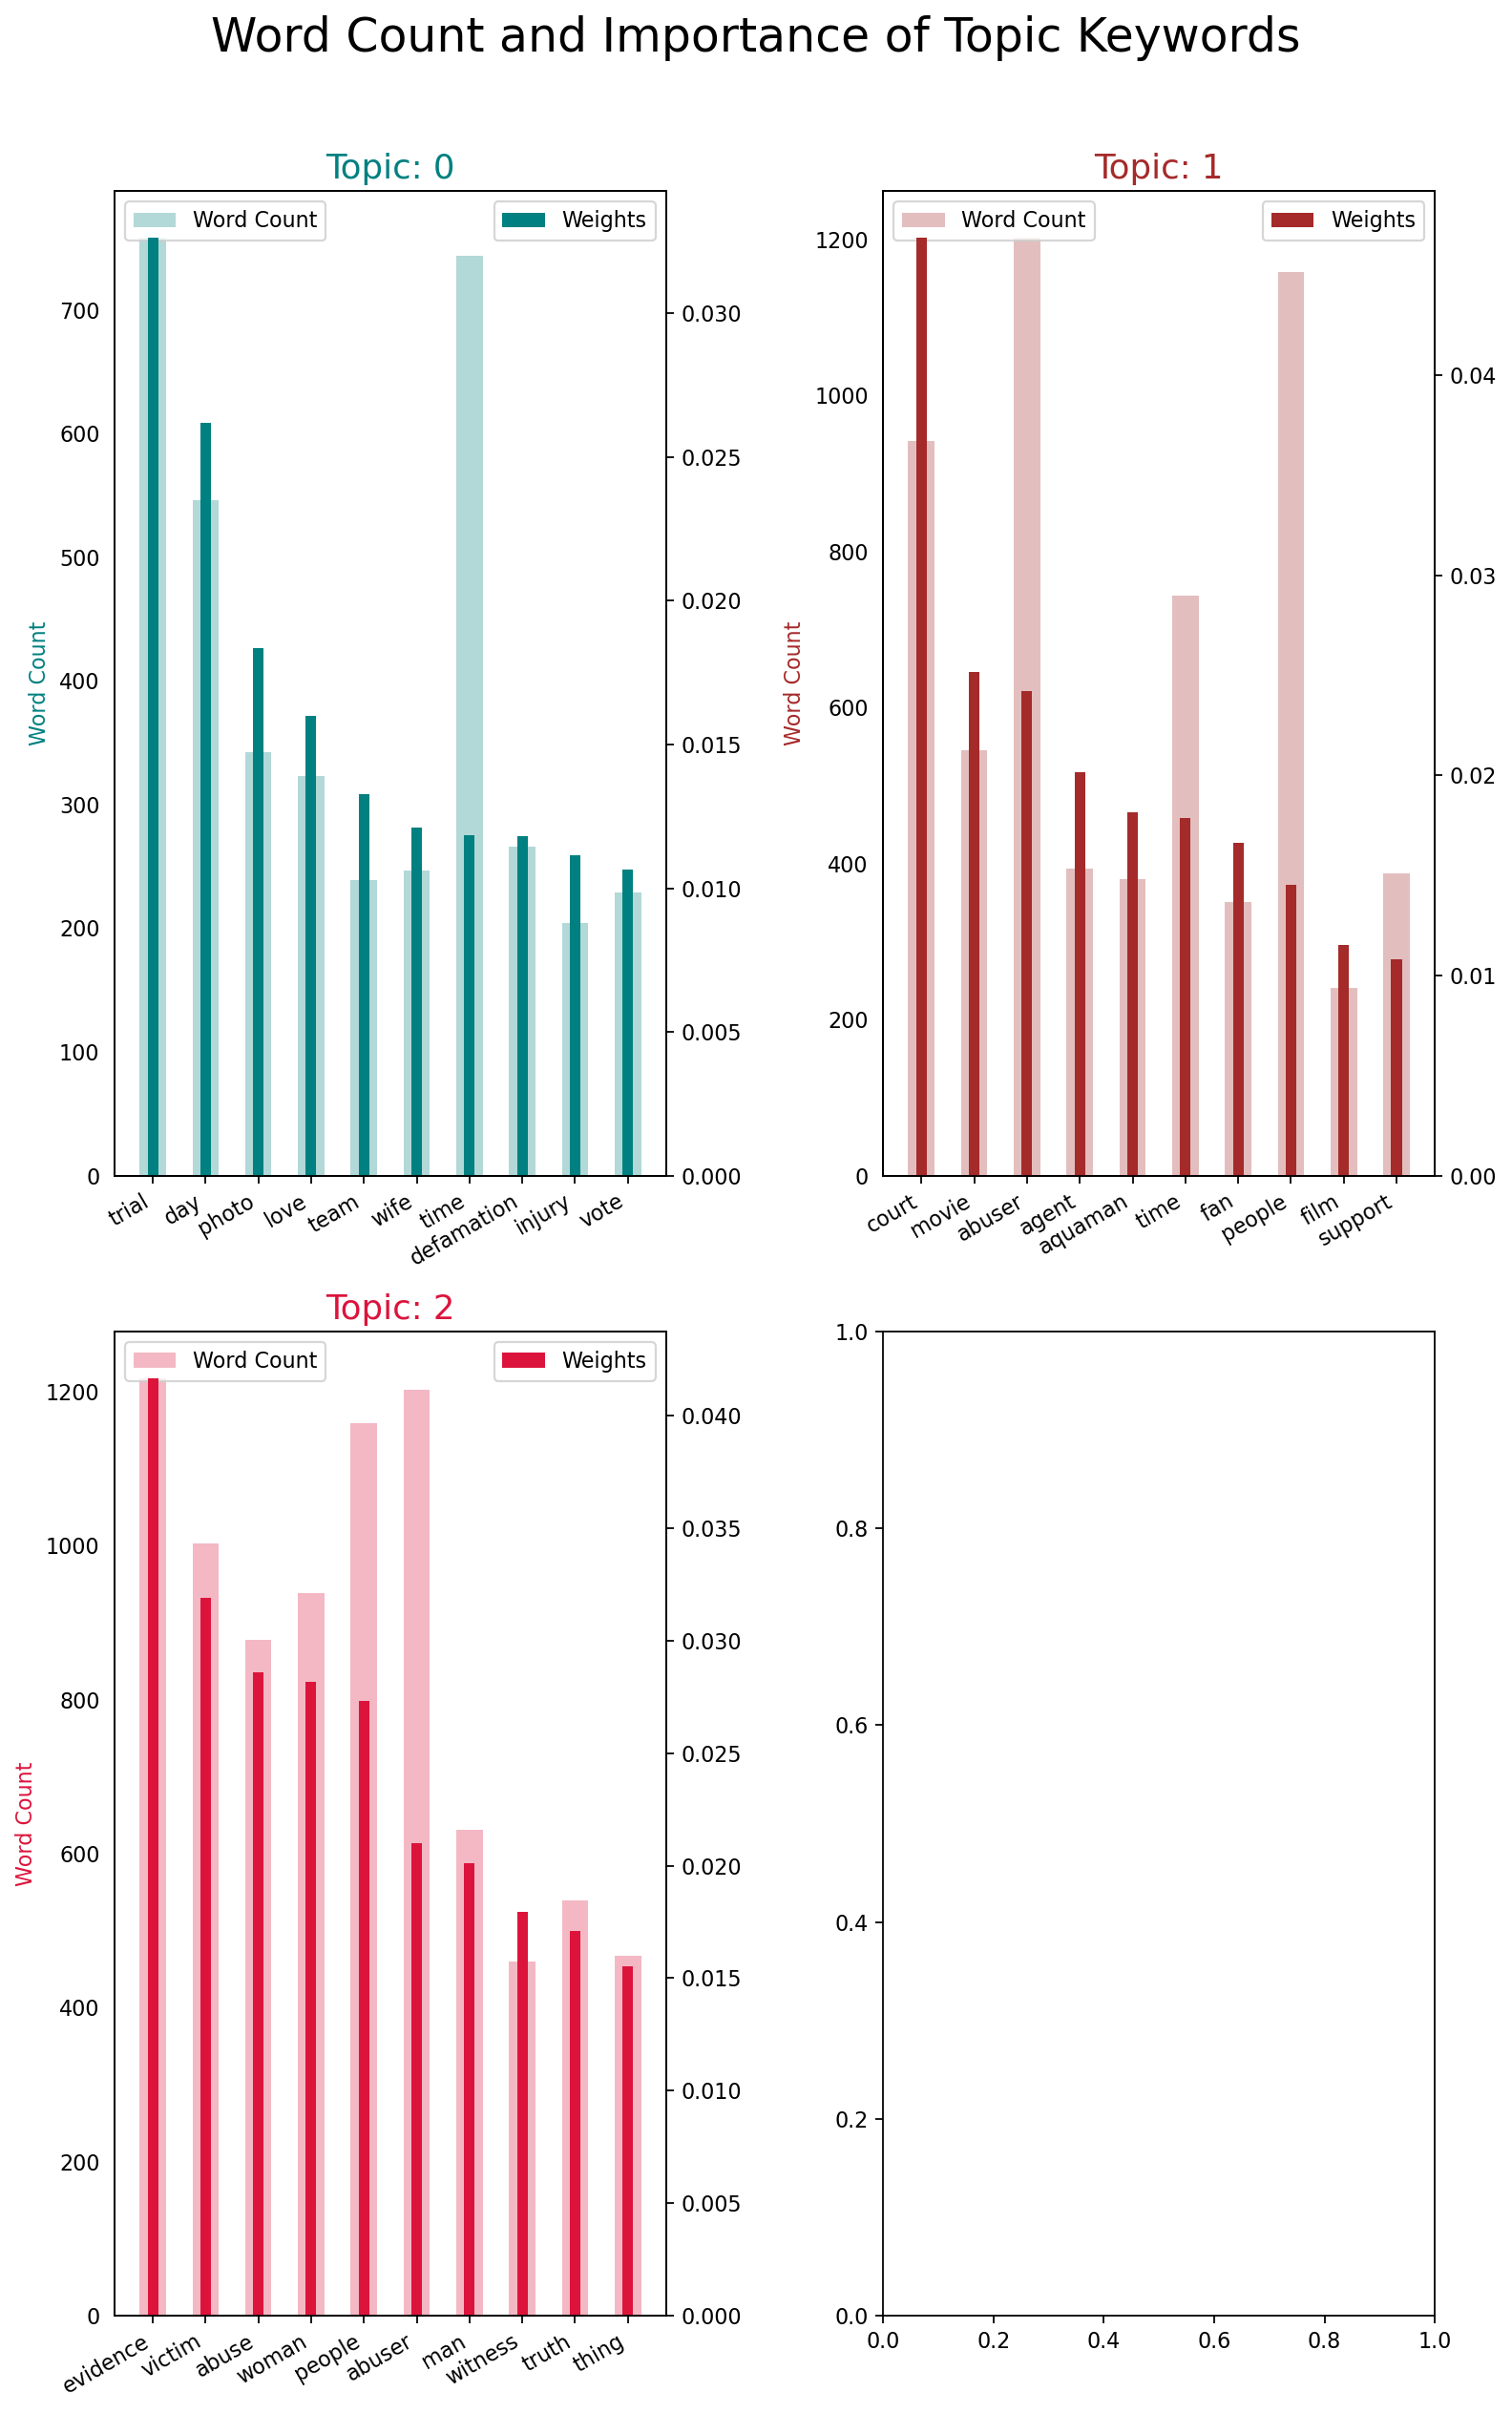

In [24]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(10,15), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('unigram_lda_topics_after.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()
